In [1]:
from __future__ import annotations

import os
import datetime
import re
import sys
sys.path.append("../utils")
import _confusion_matrix

from IPython.display import display as ipy_display
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'svg'

In [2]:
RAW_DATA_FILES = "../../data/reddit_ell_eng_raw{}.csv"
RAW_DATA_MAXLEN = ['none']

In [3]:
def encode_labels(df: pd.DataFrame, y_column: str) -> tuple[pd.DataFrame, dict]:
    """Encode labels to be used by the classifier."""
    enc = LabelEncoder()
    enc.fit(df[y_column])
    encoded_labels = dict(zip(enc.classes_, enc.transform(enc.classes_))) # will use that in the cm later
    df['label'] = enc.transform(df['label'])
    return df, encoded_labels

def group_shuffle_split(df: pd.DataFrame, group_column: str, test_size: float) -> tuple[np.ndarray, np.ndarray]:
    """Split the data into train and test sets, preserving the proportion of samples for each class."""
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size)
    train_index, test_index = next(gss.split(df, groups=df[group_column]))
    return train_index, test_index

def train_baseline(X_train: np.ndarray, y_train: np.ndarray) -> Pipeline:
    """Train a baseline classifier."""
    pipe = Pipeline([
        ('vect', CountVectorizer()),
        ('clf', SGDClassifier()),
    ])

    pipe.fit(X_train, y_train)
    return pipe

def evaluate_classifier(
    pipe: Pipeline, 
    X_test: np.ndarray, 
    y_test: np.ndarray, 
    labels: list[str],
) -> tuple[dict[str, dict[str, float]], np.ndarray]:
    """Evaluate the classifier."""
    y_pred = pipe.predict(X_test)

    cv_results = cross_validate(pipe, X_test, y_test,
                                cv=5, scoring='f1_macro', n_jobs=-1, verbose=10)

    report = classification_report(y_test, y_pred, output_dict=True)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    _confusion_matrix.plot_cm(cm, pipe=pipe, report=report, labels=labels, colorbar=False, export=True, comment='baseline')

    return report, cv_results

# To be used for GridSearchCV
def all_results_df(results: str) -> pd.DataFrame:
    """Convert all results to a DataFrame."""
    df = pd.DataFrame(results)
    df['cv_score'] = df['test_score'].apply(lambda x: round(x, 3))
    df = df.transpose()
    cols = df.columns.tolist()
    cols = [str(col) for col in cols]
    df.columns = [f"fold_{col}" for col in cols]
    ipy_display(df)
    return df


def reports_to_df(
    report: dict[str, dict[str, float]], 
    pipe: Pipeline, 
    dataset: str
) -> pd.DataFrame:
    """Save F1-macro scores from the classification report to a DataFrame."""
    clf = pipe.named_steps['clf']
    df = pd.DataFrame(report).transpose()
    df = df.drop('support', axis=1)
    df = df[df.index.str.contains('macro avg')]
    df = df.rename(index={'macro avg': 'f1'})
    df = df.rename(columns={'f1-score': dataset})
    df = df.transpose()
    # df = df.sort_values(by='f1-score', ascending=False)
    return df

def run_model(
    maxlen: str,
    test_size: float,
    random_state: int,
    n_jobs: int,
    verbose: int,
) -> pd.DataFrame:
    """Run the model."""
    df = pd.read_csv(RAW_DATA_FILES.format(maxlen), index_col=0)
    df, encoded_labels = encode_labels(df, 'label')
    train_index, test_index = group_shuffle_split(df, 'user_id', test_size)
    X_train, X_test = df['text'].iloc[train_index], df['text'].iloc[test_index]
    y_train, y_test = df['label'].iloc[train_index], df['label'].iloc[test_index]

    pipe = train_baseline(X_train, y_train)
    report = evaluate_classifier(pipe, X_test, y_test, list(encoded_labels.keys()))
    df = reports_to_df(report, pipe)

    return df

Text's maxlen: none


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


              precision    recall  f1-score   support

           0       0.77      0.67      0.72       749
           1       0.73      0.82      0.77       829

    accuracy                           0.75      1578
   macro avg       0.75      0.75      0.75      1578
weighted avg       0.75      0.75      0.75      1578

Saved confusion matrix: ../results/figures/pipelin_0.746_baseline_20230106_1018.svg


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.5s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    2.5s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.5s finished


,fold_0,fold_1,fold_2,fold_3,fold_4
fit_time,0.066459,0.059017,0.073797,0.073444,0.068457
score_time,0.010996,0.011971,0.012178,0.012010,0.019014
test_score,0.593563,0.633595,0.722949,0.815201,0.770761
cv_score,0.594000,0.634000,0.723000,0.815000,0.771000


Done



,f1,fold_0,fold_1,fold_2,fold_3,fold_4
precision,0.752013,NaN,NaN,NaN,NaN,NaN
recall,0.745375,NaN,NaN,NaN,NaN,NaN
raw_none,0.745961,NaN,NaN,NaN,NaN,NaN
fit_time,NaN,0.066459,0.059017,0.073797,0.073444,0.068457
score_time,NaN,0.010996,0.011971,0.012178,0.012010,0.019014
test_score,NaN,0.593563,0.633595,0.722949,0.815201,0.770761
cv_score,NaN,0.594000,0.634000,0.723000,0.815000,0.771000


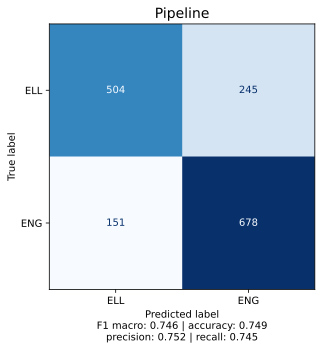

In [4]:
all_res_df = pd.DataFrame()

for maxlen in RAW_DATA_MAXLEN:
    print(f"Text's maxlen: {maxlen}")
    df = pd.read_csv(RAW_DATA_FILES.format(f"_{maxlen}" if maxlen != 'none' else ''))
    df, encoded_labels = encode_labels(df, 'label')

    train_index, test_index = group_shuffle_split(df, 'user_id', test_size=0.2)
    X_train, X_test = df['text'].iloc[train_index], df['text'].iloc[test_index]
    y_train, y_test = df['label'].iloc[train_index], df['label'].iloc[test_index]

    pipe = train_baseline(X_train, y_train)

    report, results = evaluate_classifier(pipe, X_test, y_test, list(encoded_labels.keys()))

    reports_dir = "../results/reports"
    if not os.path.exists(reports_dir):
        os.makedirs(reports_dir)
    rep_df = reports_to_df(report, pipe, f"raw_{maxlen}")
    res_df = all_results_df(results)
    all_res_df = pd.concat([all_res_df, rep_df, res_df], axis=1)
    df.to_csv(f"{reports_dir}/svm_baseline_raw_{maxlen}.csv")

    print("Done", end='\n\n')

ipy_display(all_res_df)